# Topical Expert Model

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import operator
import os
print(os.getcwd())
print(os.listdir('/Users/Brandon/Yelp Dataset/dataset'))
import json
import glob
from datetime import datetime
from pandas import HDFStore,DataFrame
import operator
import pylab as pl
import json

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib

/Users/Brandon/Yelp Dataset/Yelp-FA17/local-elites/workspace
['.DS_Store', 'business.json', 'checkin.json', 'photos.json', 'review.json', 'review5000.json', 'tip.json', 'user.json', 'user5000.json']


In [2]:
#Copied from Kenta
def load_json_to_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

LOAD THE DATA

In [3]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/review.json"
review = load_json_to_df(import_file)
review = review.drop('text', 1)

CPU times: user 1min 3s, sys: 15.3 s, total: 1min 19s
Wall time: 1min 21s


In [4]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/business.json"
business = load_json_to_df(import_file)

CPU times: user 4.8 s, sys: 192 ms, total: 4.99 s
Wall time: 5.03 s


In [5]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/user.json"
user = load_json_to_df(import_file)

CPU times: user 43.9 s, sys: 2.92 s, total: 46.8 s
Wall time: 47.4 s


Sort by category

In [6]:
def categoryFind(df, cat):
    return [cat in i for i in df['categories']]

def category_counts(df):
    all_cats = []
    for i in df['categories']:
        for j in i:
            all_cats.append(j)
    categories = set(all_cats)
    category_counts = {}
    for cat in categories:
        category_counts[cat] = all_cats.count(cat)
    return len(categories), category_counts

def top_categories(counts, n):
    top_categories = sorted(counts.keys(), key=(lambda k: counts[k]),reverse=True)[:n]
    return top_categories

In [7]:
num_cats, cat_counts = category_counts(business)
top_cats = top_categories(cat_counts, 100)
display(top_cats)

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Health & Medical',
 'Nightlife',
 'Bars',
 'Automotive',
 'Local Services',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'Sandwiches',
 'Fast Food',
 'American (Traditional)',
 'Pizza',
 'Coffee & Tea',
 'Hair Salons',
 'Hotels & Travel',
 'Arts & Entertainment',
 'Home & Garden',
 'Auto Repair',
 'Italian',
 'Burgers',
 'Doctors',
 'Breakfast & Brunch',
 'Mexican',
 'Nail Salons',
 'Professional Services',
 'American (New)',
 'Chinese',
 'Real Estate',
 'Specialty Food',
 'Fitness & Instruction',
 'Pets',
 'Grocery',
 'Bakeries',
 'Cafes',
 'Hair Removal',
 'Dentists',
 'Hotels',
 'Desserts',
 'Skin Care',
 "Women's Clothing",
 'Education',
 'Japanese',
 'Ice Cream & Frozen Yogurt',
 'Pet Services',
 'Day Spas',
 'Massage',
 'General Dentistry',
 'Financial Services',
 'Pubs',
 'Chicken Wings',
 'Seafood',
 'Contractors',
 'Salad',
 'Gyms',
 'Sushi Bars',
 'Sports Bars',
 'Apartments',
 'Caterers

In [8]:
%%time
businessReviews = pd.merge(review, business,on='business_id',right_index=True,sort=False)[['business_id', 'cool', 'funny', 'review_id', 'stars_x', 'useful', 'user_id', 'categories', 'review_count', 'stars_y']]
bus_rev_users = pd.merge(businessReviews, user,on='user_id',right_index=True,sort=False)[['business_id', 'cool_x', 'funny_x', 'review_id', 'stars_x', 'useful_x', 'user_id', 'categories', 'stars_y', 'average_stars', 'cool_y', 'elite', 'fans', 'friends', 'name', 'review_count_y', 'yelping_since']]

CPU times: user 39.3 s, sys: 7.18 s, total: 46.5 s
Wall time: 47.3 s


## Feature Extraction From Yelp Data

In [9]:
def category_choose(df, categories):
    cats = np.array([True] * len(df['categories']))
    for cat in categories:
        cats= cats & np.array(categoryFind(df,cat))
    return df[cats]

def numCategoryReviews(businessReviews):
    return businessReviews[['business_id','user_id']].groupby('user_id',as_index=False).count()

def average_star_category_rating(businessReviews):
    return businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).mean()

def std_star_category_rating(businessReviews):
    busRev = businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).agg(np.var)
    busRev['stars_x'] = busRev['stars_x'].pow(1./2)
    return busRev

def funny_useful_cool(businessReviews):
    return businessReviews[['user_id','funny','useful','cool']].groupby('user_id',as_index=False).sum()

def months_yelping(businessReviews):
    user_dates = businessReviews[['user_id','yelping_since']].drop_duplicates()
    curr_date = datetime(2017,10,17)
    uyelp_dates = [datetime.strptime(i, "%Y-%m-%d") for i in user_dates['yelping_since']]
    months_yelping = [(curr_date.year - i.year) * 12 + curr_date.month - i.month for i in uyelp_dates]
    user_dates['yelping_since'] = months_yelping
    return user_dates

def get_elite_users(df):
    temp = []
    for i in df['elite'].index.values:
        if df['elite'][i]:
            temp.append(i)
    return temp, df.loc[temp]

## Define the first feature model to be analyzed
Features: Total Reviews by User, Number of Category Reviews, Average Rating in Category, Std Dev of Ratings in Category, Funny, Useful, and Cool Votes, Number of Months since joining Yelp.

In [14]:
def feature1(df, df1, categories):
    if( not categories == "All"):
        df = category_choose(df, categories)
        df1 = category_choose(df1, categories)
    tot_reviews = df1[['user_id','review_count_y']]
    tot_reviews.columns = ['user_id','Total Reviews by User']
    catRev = numCategoryReviews(df)
    catRev.columns = ['user_id','Num Category Reviews']
    averageCat = average_star_category_rating(df)
    averageCat.columns = ['user_id','Average Rating in Category']
    stdCat = std_star_category_rating(df)
    stdCat.columns = ['user_id','Std Dev of Ratings in Category']
    fuc = funny_useful_cool(df)
    monthsYelp = months_yelping(df1)
    monthsYelp.columns = ['user_id', 'Months Yelping']
    is_elite = df1[['user_id','elite']]
    features = tot_reviews.merge(catRev,on='user_id').merge(averageCat,on='user_id').merge(stdCat,on='user_id').merge(fuc,on='user_id').merge(monthsYelp,on='user_id').merge(is_elite,on='user_id')
    features = features.drop_duplicates('user_id')
    features.index = range(len(features))
    elite_ind, elite_users = get_elite_users(features)
    expertClassifier = [0]*len(features)
    for i in elite_ind:
        expertClassifier[i]=1
    features = pd.concat([features, pd.DataFrame(expertClassifier,columns=['is_expert'])],axis=1)
    return features.fillna(0)

# Feature 2 has all of feature 1 plus the number of friends for each user
def feature2(df, df1, categories, features1 = pd.DataFrame()):
    if features1.empty:
        features1= feature1(df,df1,categories)
    
    friends = pd.DataFrame([len(i) for i in df1['friends']], columns = ['Num_Friends'])
    users = pd.DataFrame(df1['user_id'].values,columns=['user_id'])
    num_friends = pd.concat([users, friends],axis=1)
    features1= features1.merge(num_friends,on='user_id').drop_duplicates('user_id')
    features1.index = range(len(features1))
    return features1

# Unsupervised Learning
## Kmeans Cluster

In [15]:
'''Runs the model specified by the clf (classifier), and features.
Features is assumed to have an 'is_expert' column which gives comparisons to unsupervised learning'''
from sklearn.cluster import KMeans
def run_unsup_model(clf, features):
    train = features.drop('is_expert',axis=1)
    clf.fit(train)
    rf_pred = clf.predict(train)
    model_perf= {'Model_Score' : clf.score(train),
                'Predictions' : rf_pred,
                'Total_Tested' : len(rf_pred),
                'Num_Experts_Predicted' : sum(rf_pred),
                'Num_Non_Experts' : sum(1-rf_pred),
                'Cluster_Centers' : clf.cluster_centers_,
                'Cluster_Points' : clf.transform(train)} 
    return model_perf

def graph_clusters(model):
    x = model['Cluster_Points'][:,0]
    y = model['Cluster_Points'][:,1]
    labels = model['Predictions']
    plt.scatter(x, y, c=[matplotlib.cm.spectral(float(i) /10) for i in labels]);   
    plt.show()

def add_pred_column(model, features):
    return features.assign(preds=pd.Series(model['Predictions']).values)

def unsup_statistics(model, features):
    features = add_pred_column(model, features)
    return {'Num_Experts' : sum(features.is_expert),
            'Num_Experts_Predicted' : sum(features.preds),
            'Intersection' : sum(features.is_expert & features.preds)}

def kmeans_model(n_clusters, X, feature_set):
    clf_KMeans = KMeans(n_clusters=n_clusters)
    model_test = run_unsup_model(clf_KMeans, X)
    display(graph_clusters(model_test))
    display(unsup_statistics(model_test, X))
    predictions = add_pred_column(model_test, feature_set)
    return predictions

## Evaluation Model

In [28]:
from sklearn.metrics import mean_squared_error
def evaluate_category(businessReviews, categories, category_features):
    bus_revs = category_choose(businessReviews, categories)[['business_id', 'review_id', 'user_id', 'stars_x', 'stars_y',]]
    
    cat_feat = category_features[['user_id', 'preds']]
    
    bus_revs_preds = pd.merge(bus_revs, cat_feat, on='user_id',right_index=True,sort=False).sort_values('business_id')
    bus_revs_preds.index = range(len(bus_revs_preds['business_id']))
    
    topic_evaluate = pd.DataFrame(columns=[['business_id', 'expert_stars','num_experts', 'avg_exp_stars', 'user_stars','num_users', 'avg_user_stars']])
    topic_evaluate['business_id']= bus_revs_preds.drop_duplicates('business_id')['business_id']
    topic_evaluate.index = range(len(topic_evaluate['business_id']))
    
    for i in range(0, len(topic_evaluate)):
        temp_bid = topic_evaluate['business_id'][i]
        temp_bus = bus_revs_preds[bus_revs_preds.business_id.isin([temp_bid])]
        temp_experts = temp_bus[temp_bus.preds==1]
        temp_users = temp_bus[temp_bus.preds==0]
        topic_evaluate['expert_stars'][i] = temp_experts['stars_x'].sum()
        topic_evaluate['num_experts'][i] = len(temp_experts)
        topic_evaluate['avg_exp_stars'][i] = temp_experts['stars_x'].mean()
        topic_evaluate['user_stars'][i] = temp_users['stars_x'].sum()
        topic_evaluate['num_users'][i] = len(temp_users)
        topic_evaluate['avg_user_stars'][i] = temp_users['stars_x'].mean()
    return topic_evaluate

def evaluate_category_stats(cat_evals, categories, plot):
    num_bus = len(cat_evals)
    cat_evals = cat_evals.dropna()
    diffs = (cat_evals['avg_exp_stars'] - cat_evals['avg_user_stars'])
    if(plot):
        diffs.plot(kind='hist')
        plt.show()
        
        tmp1 = []
        for i in range(1,30):
            tmp1.append(len(cat_evals[cat_evals.num_experts==i]))
        pd.DataFrame(tmp1,columns=['Frequency']).plot(y='Frequency')
        plt.show()
        
    num_bus_with_experts = len(diffs)
    mean_diff = abs(diffs).mean()
    avg_user_stars = cat_evals['avg_user_stars'].mean()
    if not cat_evals['avg_exp_stars'].empty:
        MSE = mean_squared_error(cat_evals['avg_user_stars'], cat_evals['avg_exp_stars'])
        avg_expert_stars = cat_evals['avg_exp_stars'].mean() 
    else:
        MSE = np.nan
        avg_expert_stars = np.nan
    cat_dict = {'Categories': categories, 'Number of Businesses' : num_bus, 
                'Number of Businesses with Experts' : num_bus_with_experts,
                'MAE' : mean_diff, 
                'MSE' : MSE, 'Average Expert Stars' : avg_expert_stars, 
                'Average User Stars': avg_user_stars}
    return cat_dict
    
def evaluate_category_single(businessReviews, categories, category_features, plot):
    return evaluate_category_stats(evaluate_category(businessReviews, categories, category_features), categories, plot)

def evaluate_categories(businessReviews, bus_rev_users, categories, plot):
    evaluation = pd.DataFrame()
    if type(categories) == str:
        categories = [categories]
    for cat in categories:
        if type(cat) == str:
            cat = [cat]
        feature_set = feature1(businessReviews, bus_rev_users, cat)
        if feature_set.empty:
            continue
        X = feature_set.drop('user_id',axis=1).drop('elite',axis=1)
        cat_features = kmeans_model(n_clusters = 2, X=X, feature_set = feature_set)
        this_eval = evaluate_category_single(businessReviews, cat, cat_features, plot)
        display(this_eval)
        evaluation = evaluation.append(pd.DataFrame(pd.Series(this_eval)).transpose())
    return evaluation

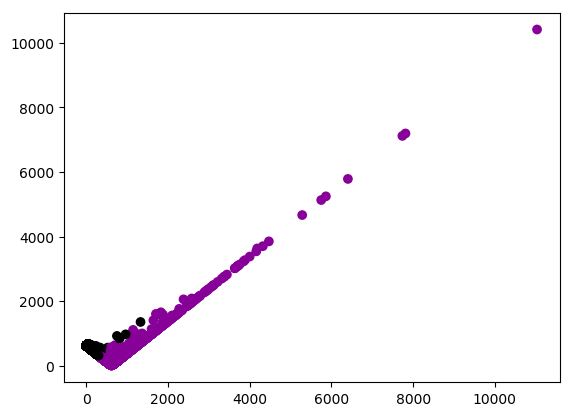

None

{'Intersection': 6536, 'Num_Experts': 28185, 'Num_Experts_Predicted': 7278}

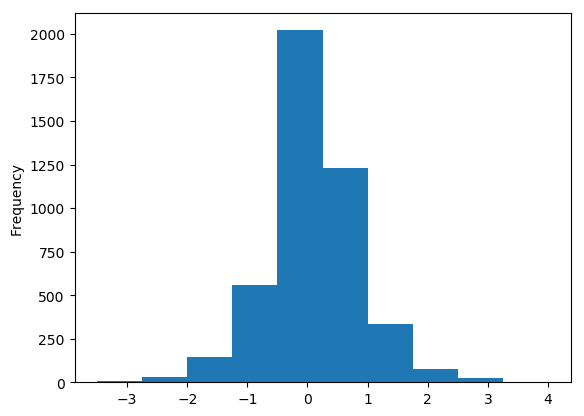

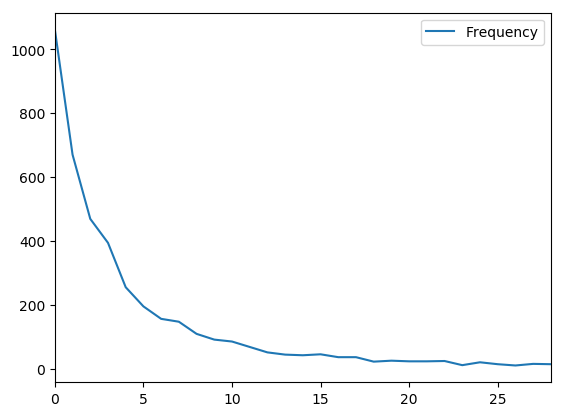

{'Average Expert Stars': 3.3971154454053201,
 'Average User Stars': 3.3186548485485972,
 'Categories': ['American (Traditional)'],
 'MSE': 0.57727641888730308,
 'Mean Absolute Difference by Business': 0.55200537788852333,
 'Number of Businesses': 5737,
 'Number of Businesses with Experts': 4429}

In [25]:
single_cat = evaluate_categories(businessReviews, bus_rev_users, top_cats[15], True)

In [26]:
single_cat

,Average Expert Stars,Average User Stars,Categories,MSE,Mean Absolute Difference by Business,Number of Businesses,Number of Businesses with Experts
0,3.39712,3.31865,[American (Traditional)],0.577276,0.552005,5737,4429


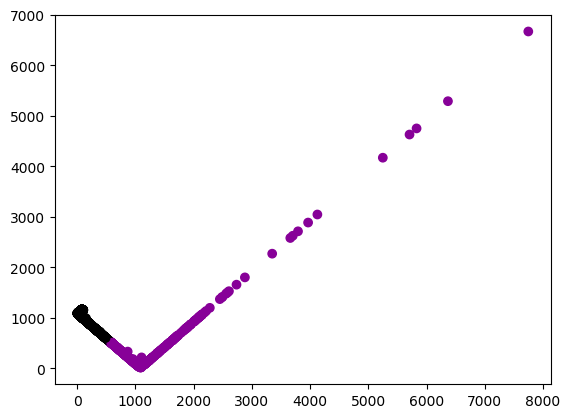

None

{'Intersection': 471, 'Num_Experts': 2768, 'Num_Experts_Predicted': 511}

{'Average Expert Stars': 3.7462389034025416,
 'Average User Stars': 3.641954338911872,
 'Categories': ['Accessories'],
 'MSE': 1.0716457240961292,
 'Mean Absolute Difference by Business': 0.76728682717009433,
 'Number of Businesses': 1600,
 'Number of Businesses with Experts': 738}

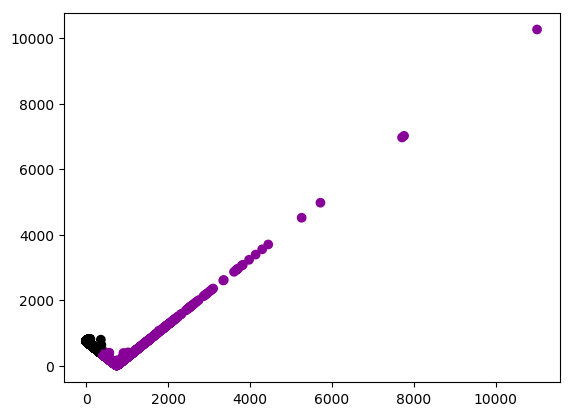

None

{'Intersection': 2835, 'Num_Experts': 13509, 'Num_Experts_Predicted': 3119}

{'Average Expert Stars': 3.7428507844243377,
 'Average User Stars': 3.6871993942364343,
 'Categories': ['Venues & Event Spaces'],
 'MSE': 0.59857016344817571,
 'Mean Absolute Difference by Business': 0.56225436143680241,
 'Number of Businesses': 1565,
 'Number of Businesses with Experts': 1040}

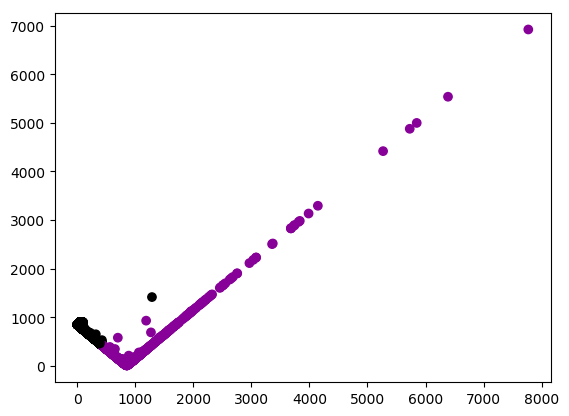

None

{'Intersection': 1325, 'Num_Experts': 8269, 'Num_Experts_Predicted': 1469}

{'Average Expert Stars': 3.6585702481608178,
 'Average User Stars': 3.6261664666978337,
 'Categories': ['Delis'],
 'MSE': 0.6812494149192726,
 'Mean Absolute Difference by Business': 0.61236766794503494,
 'Number of Businesses': 1564,
 'Number of Businesses with Experts': 984}

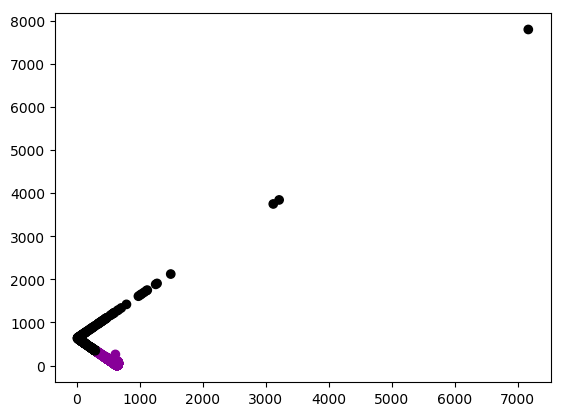

None

{'Intersection': 1055, 'Num_Experts': 1358, 'Num_Experts_Predicted': 22389}

{'Average Expert Stars': 4.0092358689383003,
 'Average User Stars': 4.0252965303527102,
 'Categories': ['Hair Stylists'],
 'MSE': 0.97843993027519938,
 'Mean Absolute Difference by Business': 0.69804354660028367,
 'Number of Businesses': 1557,
 'Number of Businesses with Experts': 267}

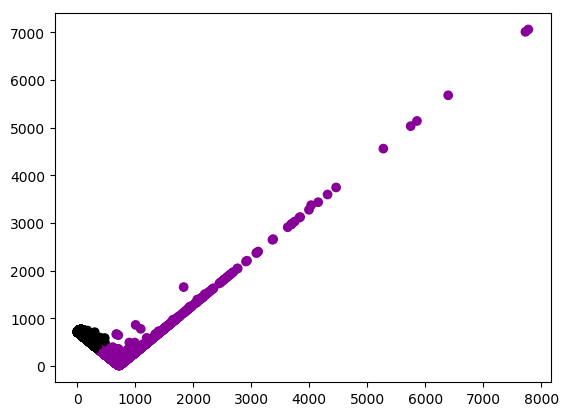

None

{'Intersection': 3015, 'Num_Experts': 15405, 'Num_Experts_Predicted': 3289}

{'Average Expert Stars': 3.4793880278937879,
 'Average User Stars': 3.5722019801777924,
 'Categories': ['Asian Fusion'],
 'MSE': 0.50916558721840133,
 'Mean Absolute Difference by Business': 0.52049630009513348,
 'Number of Businesses': 1554,
 'Number of Businesses with Experts': 1115}

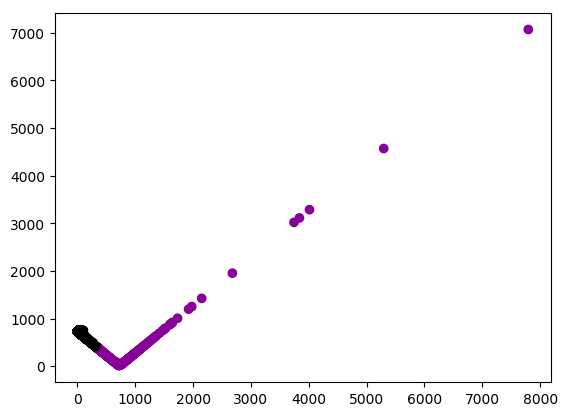

None

{'Intersection': 307, 'Num_Experts': 1717, 'Num_Experts_Predicted': 341}

{'Average Expert Stars': 3.9788186653369904,
 'Average User Stars': 3.9635369054800953,
 'Categories': ['Barbers'],
 'MSE': 1.2520541850644016,
 'Mean Absolute Difference by Business': 0.85172435458801021,
 'Number of Businesses': 1543,
 'Number of Businesses with Experts': 382}

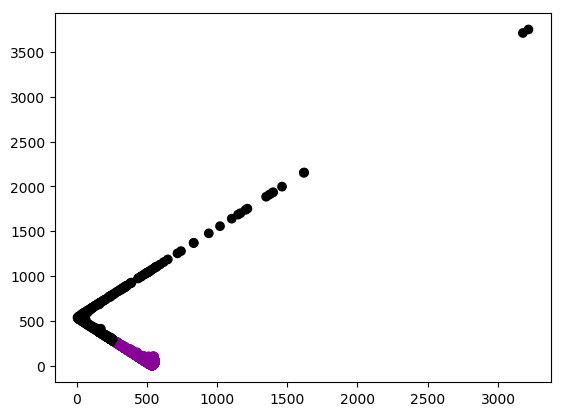

None

{'Intersection': 1755, 'Num_Experts': 2221, 'Num_Experts_Predicted': 34768}

{'Average Expert Stars': 4.0743014984642567,
 'Average User Stars': 4.0122823332291491,
 'Categories': ['Waxing'],
 'MSE': 1.1105294154373995,
 'Mean Absolute Difference by Business': 0.7390849786150766,
 'Number of Businesses': 1483,
 'Number of Businesses with Experts': 439}

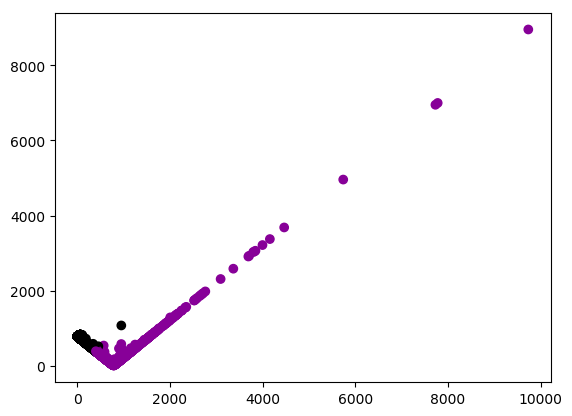

None

{'Intersection': 1407, 'Num_Experts': 9447, 'Num_Experts_Predicted': 1554}

{'Average Expert Stars': 3.6572166346262303,
 'Average User Stars': 3.7802936322219463,
 'Categories': ['Mediterranean'],
 'MSE': 0.62533701948076481,
 'Mean Absolute Difference by Business': 0.58098281730501899,
 'Number of Businesses': 1482,
 'Number of Businesses with Experts': 939}

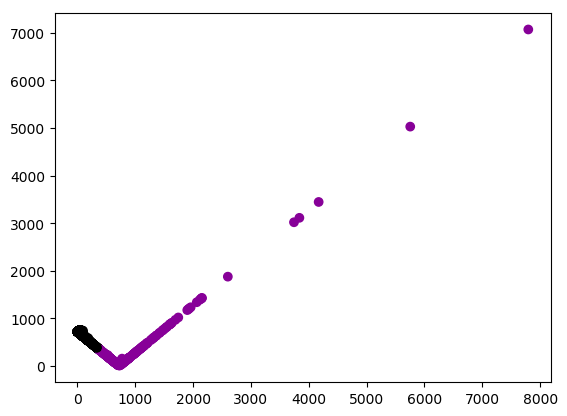

None

{'Intersection': 386, 'Num_Experts': 1927, 'Num_Experts_Predicted': 420}

{'Average Expert Stars': 3.8240900383141767,
 'Average User Stars': 3.612298463981042,
 'Categories': ['Auto Parts & Supplies'],
 'MSE': 1.376309303248928,
 'Mean Absolute Difference by Business': 0.89065158849216497,
 'Number of Businesses': 1479,
 'Number of Businesses with Experts': 522}

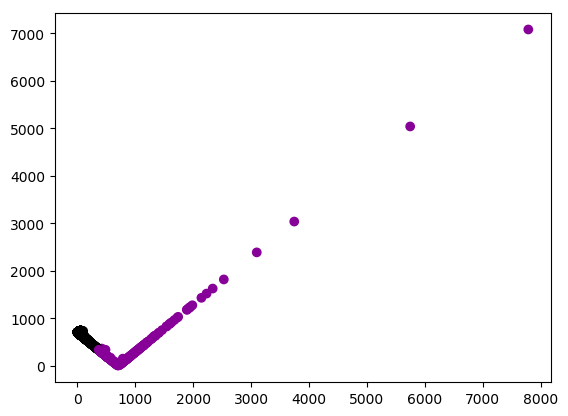

None

{'Intersection': 398, 'Num_Experts': 2255, 'Num_Experts_Predicted': 429}

{'Average Expert Stars': 3.9159688654643818,
 'Average User Stars': 3.7283492914314111,
 'Categories': ['Trainers'],
 'MSE': 1.0937436538118417,
 'Mean Absolute Difference by Business': 0.73889631814296031,
 'Number of Businesses': 1478,
 'Number of Businesses with Experts': 446}

CPU times: user 3min 33s, sys: 16.3 s, total: 3min 49s
Wall time: 4min


In [20]:
%%time
EVALUATION = evaluate_categories(businessReviews, bus_rev_users, top_cats[70:80], False)

In [21]:
EVALUATION

,Average Expert Stars,Average User Stars,Categories,MSE,Mean Absolute Difference by Business,Number of Businesses,Number of Businesses with Experts
0,3.74624,3.64195,[Accessories],1.07165,0.767287,1600,738
0,3.74285,3.6872,[Venues & Event Spaces],0.59857,0.562254,1565,1040
0,3.65857,3.62617,[Delis],0.681249,0.612368,1564,984
0,4.00924,4.0253,[Hair Stylists],0.97844,0.698044,1557,267
0,3.47939,3.5722,[Asian Fusion],0.509166,0.520496,1554,1115
0,3.97882,3.96354,[Barbers],1.25205,0.851724,1543,382
0,4.0743,4.01228,[Waxing],1.11053,0.739085,1483,439
0,3.65722,3.78029,[Mediterranean],0.625337,0.580983,1482,939
0,3.82409,3.6123,[Auto Parts & Supplies],1.37631,0.890652,1479,522
0,3.91597,3.72835,[Trainers],1.09374,0.738896,1478,446


In [22]:
out = EVALUATION.to_json(orient='records', lines=True)

In [23]:
with open('../evaluation/category_evaluation.txt', 'w') as f:
    f.write(out)